In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import ml_metrics as metrics

# Data Engineering

In [3]:
dtype_train ={'is_booking':bool,
            'srch_ci' : np.str_,
            'srch_co' : np.str_,
            'srch_adults_cnt' : np.int32,
            'srch_children_cnt' : np.int32,
            'srch_rm_cnt' : np.int32,
            'srch_destination_id':np.str_,
            'user_location_country' : np.str_,
            'user_location_region' : np.str_,
            'user_location_city' : np.str_,
            'hotel_cluster' : np.str_,
            'orig_destination_distance':np.float64,
            'date_time':np.str_,
            'hotel_market':np.str_}

In [1]:
# load train data
train = pd.read_csv('train.csv', parse_dates = ['date_time'], sep = ',', nrows = 2000000)

NameError: name 'pd' is not defined

In [4]:
# load train data
train = pd.read_csv('train.csv', dtype = dtype_train, usecols = dtype_train, parse_dates = ['date_time'], sep = ',', nrows = 2000000)

In [5]:
print train.shape

(2000000, 14)


In [6]:
# special handling of train data, take only 2014 data and is_booking == True
train['year'] = train['date_time'].dt.year
train = train.query('is_booking==True & year==2014')
train.drop(['year', 'is_booking'], axis=1, inplace = True)

print train.shape

(107553, 13)


In [7]:
def prepare_data_before_modeling(df):
    # add new predictors of plan_time and hotel_nights
    df['srch_ci'] = pd.to_datetime(df['srch_ci'], infer_datetime_format = True, errors='coerce')
    df['srch_co'] = pd.to_datetime(df['srch_co'], infer_datetime_format = True, errors='coerce')
    df['plan_time'] = ((df['srch_ci'] - df['date_time']) / np.timedelta64(1,'D')).astype(float)
    df['hotel_nights']=((df['srch_co'] - df['srch_ci']) / np.timedelta64(1,'D')).astype(float)
    
    # fill in the NAs
    distance_mean = df.orig_destination_distance.mean()
    df['orig_destination_distance'] = df.orig_destination_distance.fillna(distance_mean)
    df.fillna(-1,inplace=True)
    
    # drop some unused columns
    drop_columns = ['date_time', 'srch_ci', 'srch_co']
    df.drop(drop_columns, axis=1, inplace = True)
    
    return df

In [8]:
train = prepare_data_before_modeling(train)
train.shape

(107553, 12)

In [9]:
train.columns

Index([u'user_location_country', u'user_location_region',
       u'user_location_city', u'orig_destination_distance', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'hotel_market', u'hotel_cluster', u'plan_time', u'hotel_nights'],
      dtype='object')

# Modeling

In [10]:
# split the train into train and validation sets
train_predictors, vali_predictors, train_labels, vali_labels = train_test_split(train.drop('hotel_cluster', axis = 1), train['hotel_cluster'], test_size = 0.3)

In [11]:
print train_predictors.shape, train_labels.shape, vali_predictors.shape, vali_labels.shape

(75287, 11) (75287,) (32266, 11) (32266,)


In [12]:
# apply random forest to train the model
rf_tree = RandomForestClassifier(n_estimators = 31, max_depth = 10, random_state = 123)
rf_tree.fit(train_predictors, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [13]:
# show the importance of each feature
importance = rf_tree.feature_importances_
importance

array([ 0.06158297,  0.07721577,  0.06804035,  0.12367223,  0.02739838,
        0.01915325,  0.01340586,  0.19040283,  0.2787206 ,  0.08889477,
        0.05151299])

In [14]:
np.argsort(importance)

array([ 6,  5,  4, 10,  0,  2,  1,  9,  3,  7,  8])

In [15]:
indices=np.argsort(importance)[::-1][:10]

In [16]:
importance[indices]

array([ 0.2787206 ,  0.19040283,  0.12367223,  0.08889477,  0.07721577,
        0.06804035,  0.06158297,  0.05151299,  0.02739838,  0.01915325])

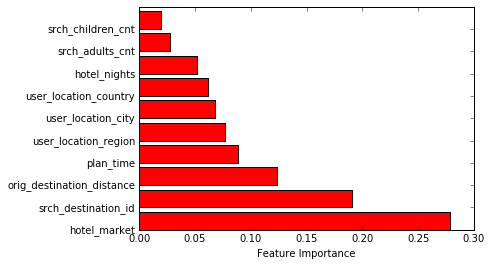

In [17]:
plt.barh(range(10), importance[indices],color='r')
plt.yticks(range(10), train_predictors.columns[indices])
plt.xlabel('Feature Importance')
plt.show()

In [18]:
# show the clusters
rf_tree.classes_

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98',
       '99'], dtype=object)

In [19]:
# function to return 5 prediction clusters
def predict_clusters(model, predictors):
    # save the cluster index in the model for later ranking
    dict_clusters = {}
    for (k,v) in enumerate(model.classes_):
        dict_clusters[k] = v
    
    # validate the modeling
    vali_predictions = model.predict_proba(predictors)
    # take largest 5 probablities' index
    clusters_index = vali_predictions.argsort(axis=1)[:, -5:]
    
    # get cluster name by 5 index
    clusters = []
    for index in clusters_index.flatten():
        clusters.append(dict_clusters.get(index))
    
    # get the cluster predictions
    cluster_predictions = np.array(clusters).reshape(clusters_index.shape)
    
    return cluster_predictions

In [20]:
cluster_predictions = predict_clusters(rf_tree, vali_predictors)
cluster_predictions

array([['78', '61', '62', '81', '82'],
       ['82', '61', '81', '43', '36'],
       ['67', '62', '36', '38', '82'],
       ..., 
       ['28', '72', '48', '91', '42'],
       ['72', '28', '48', '42', '91'],
       ['64', '98', '21', '25', '59']], 
      dtype='|S2')

In [21]:
# calculate the scores
print("score:", metrics.mapk(vali_labels, cluster_predictions, k=5))

('score:', 0.088023512882497587)


# Test Modeling

In [22]:
dtype_test ={'srch_ci' : np.str_,
            'srch_co' : np.str_,
            'srch_adults_cnt' : np.int32,
            'srch_children_cnt' : np.int32,
            'srch_rm_cnt' : np.int32,
            'srch_destination_id':np.str_,
            'user_location_country' : np.str_,
            'user_location_region' : np.str_,
            'user_location_city' : np.str_,
            'orig_destination_distance':np.float64,
            'date_time':np.str_,
            'hotel_market':np.str_}

In [31]:
# load test data
test = pd.read_csv('test.csv', dtype = dtype_test, usecols = dtype_test, parse_dates = ['date_time'], sep = ',', nrows = 1000000)

In [32]:
# feature cleaning
test = prepare_data_before_modeling(test)
test.shape

(1000000, 11)

In [33]:
# apply model on test set
predictions_test = predict_clusters(rf_tree, test)
predictions_test

array([['11', '25', '5', '37', '64'],
       ['62', '58', '36', '67', '82'],
       ['28', '15', '61', '21', '91'],
       ..., 
       ['95', '18', '42', '48', '91'],
       ['32', '7', '91', '42', '48'],
       ['50', '32', '42', '48', '91']], 
      dtype='|S2')

In [34]:
len(predictions_test)

1000000

# Output test results

In [35]:
predictions_output = map(lambda x: ' '.join(map(str,x)), predictions_test)
predictions_output

['11 25 5 37 64',
 '62 58 36 67 82',
 '28 15 61 21 91',
 '24 54 45 79 1',
 '16 28 48 42 91',
 '32 28 48 42 91',
 '98 18 48 42 91',
 '59 18 48 95 91',
 '91 79 24 45 1',
 '21 4 48 95 91',
 '18 21 70 98 91',
 '18 48 6 91 59',
 '91 78 38 43 30',
 '67 39 78 36 43',
 '36 91 99 16 97',
 '16 97 20 99 43',
 '56 34 43 38 30',
 '58 38 43 62 20',
 '86 91 43 99 36',
 '78 38 43 30 20',
 '16 86 43 36 99',
 '82 43 78 29 36',
 '61 65 31 67 43',
 '44 78 30 36 43',
 '70 43 41 56 98',
 '69 41 98 70 56',
 '59 81 64 62 46',
 '16 50 39 48 91',
 '32 7 42 48 91',
 '26 87 52 66 65',
 '59 58 29 2 64',
 '6 62 50 77 40',
 '16 32 42 48 91',
 '88 24 45 79 1',
 '91 4 70 98 19',
 '32 28 42 48 91',
 '32 7 48 42 91',
 '28 32 42 48 91',
 '99 82 98 64 46',
 '19 48 42 70 91',
 '62 36 46 58 63',
 '9 58 64 36 46',
 '16 47 42 48 91',
 '24 54 79 45 1',
 '21 95 28 55 91',
 '72 41 48 42 91',
 '16 50 42 48 91',
 '72 28 48 42 91',
 '59 48 11 4 21',
 '32 39 51 48 91',
 '42 16 77 48 91',
 '77 16 42 48 91',
 '50 32 48 42 91',
 '62 36

In [36]:
len(predictions_output)

1000000

In [37]:
# load test data
submission = pd.read_csv('sample_submission.csv', sep = ',', nrows = 1000000)

In [38]:
len(submission)

1000000

In [39]:
submission['hotel_cluster'] = predictions_output

In [51]:
submission[['id', 'hotel_cluster']].to_csv('out.csv', index = False)